In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read in the file. Separate target from predictors in $y$ and $X$.

In [59]:
d = pd.read_hdf('../data/shower-shapes.h5')

In [60]:
y = d['shower_class'].values
del d['shower_class']

In [61]:
d.shape

(300000, 20)

In [62]:
X = d.values

Turn labels into classes, and select only photons and positrons for e-gamma classification.

In [63]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [64]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['eplus', 'gamma', 'piplus'], dtype=object)

0 = $e^+$

1 = $\gamma$

2 = $\pi^+$

In [65]:
# cut out pi+ for now
X = X[y != 2]
y = y[y != 2]

In [66]:
ix = range(len(y))

In [67]:
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(
    X, y, ix, train_size=0.65)

Train a series of BDTs with cross validation for hyperparam search.

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [102]:
base_clf = GradientBoostingClassifier(verbose=2)
parameters = {
    'n_estimators':[100, 200, 300],
    'max_depth':[3]
}

In [105]:
clf = GridSearchCV(base_clf, parameters, n_jobs=4)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
         1           1.3593            2.00m
         1           1.3596            1.69m
         1           1.3595            2.08m
         1           1.3595            3.63m
         2           1.3376            1.72m
         2           1.3370            1.92m
         2           1.3374            2.02m
         2           1.3374            3.69m
         3           1.3192            1.70m
         3           1.3188            1.86m
         3           1.3193            1.89m
         3           1.3193            3.65m
         4           1.3032            1.79m
         4           1.3033            1.70m
         4           1.3035            1.83m
         4           1.3035            3.58m
         5           1.2905            1.73m
         5           1.2904            1.68m
      

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100, 200, 300], 'max_depth': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [106]:
clf.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=2, warm_start=False)

Check classifier performance using different metrics:

In [107]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

In [108]:
y_hat = clf.predict(X_test)

In [109]:
y_hat_prob = clf.predict_proba(X_test)

In [110]:
print classification_report(y_test, y_hat)

             precision    recall  f1-score   support

          0       0.62      0.83      0.71     35065
          1       0.74      0.48      0.59     34935

avg / total       0.68      0.66      0.65     70000



In [202]:
accuracy_score(y_test, y_hat)

0.65941428571428573

In [203]:
roc_auc_score(y_test>0, y_hat_prob[:, 1])

0.70147042425513673

In [204]:
fpr, tpr, _ = roc_curve(y_test>0, y_hat_prob[:, 1])

In [115]:
np.save('ix_egamma.npy', ix)

Train a NN on this same problem

In [237]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

x = Input(shape=(X_train.shape[-1], ))

h = Dense(256)(x)
h = Dropout(0.2)(LeakyReLU()(h))
h = BatchNormalization()(h)

h = Dense(256)(h)
h = Dropout(0.5)(LeakyReLU()(h))
h = BatchNormalization()(h)

h = Dense(256)(h)
h = Dropout(0.5)(LeakyReLU()(h))
h = BatchNormalization()(h)

h = Dense(32)(h)
h = Dropout(0.5)(LeakyReLU()(h))

h = Dense(1)(h)
y = Activation('sigmoid')(h)

net = Model(inputs=x, outputs=y)

In [238]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 20)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               5376      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_36 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 256)               0         
__________

In [239]:
net.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [227]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Plot the scaled input variables just to make sure nothing went wrong

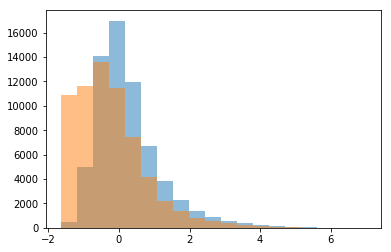

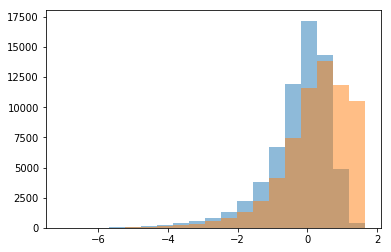

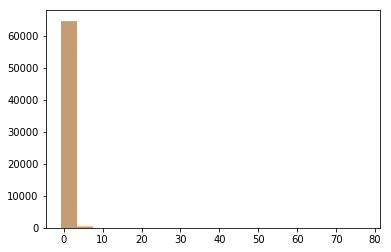

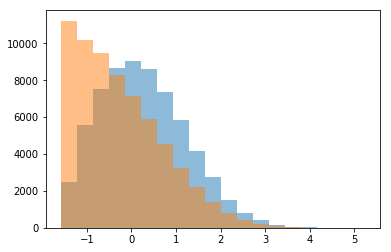

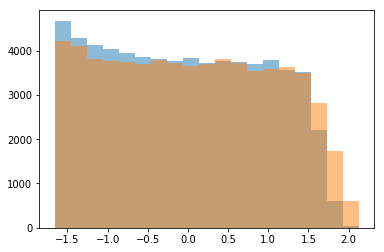

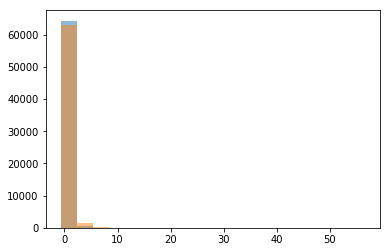

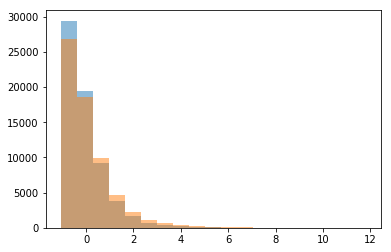

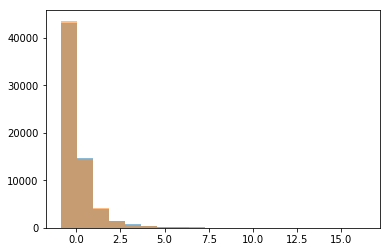

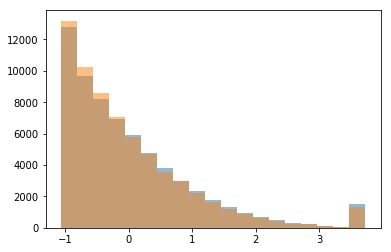

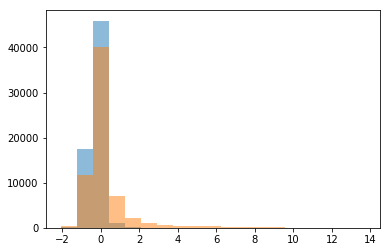

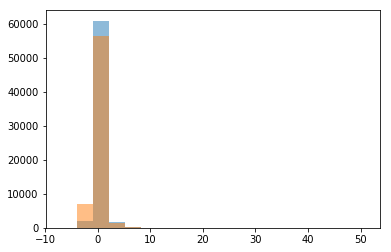

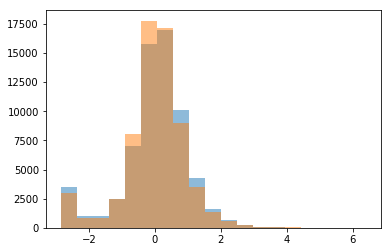

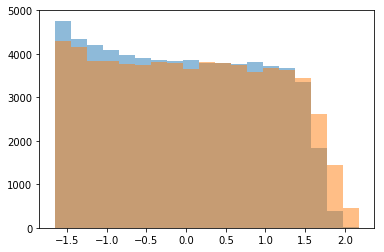

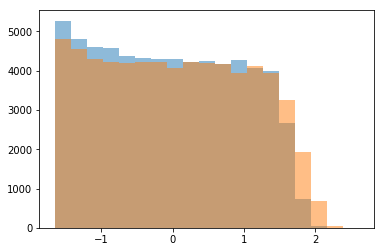

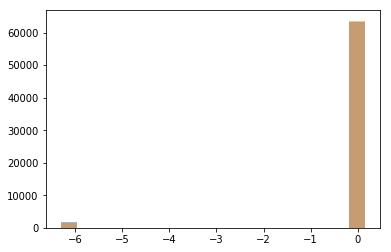

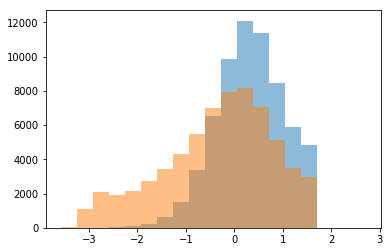

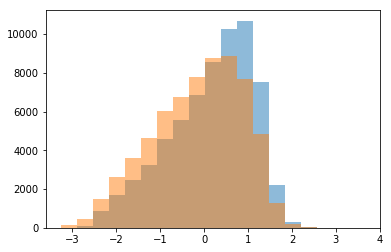

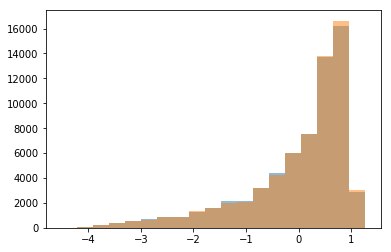

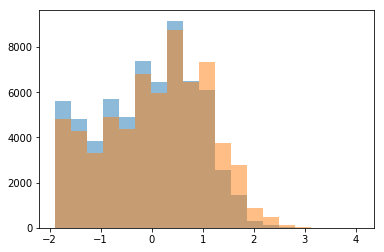

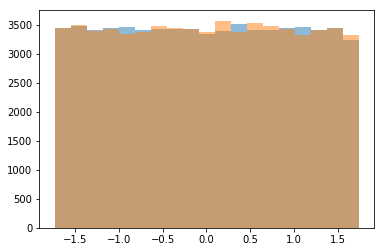

In [241]:
for i in range(X_train.shape[1]):
    bins = np.linspace(X_train_scaled[:, i].min(), X_train_scaled[:, i].max(), 20)
    _ = plt.hist(X_train_scaled[:, i][y_train == 0], alpha=0.5, bins=bins)
    _ = plt.hist(X_train_scaled[:, i][y_train == 1], alpha=0.5, bins=bins)
    plt.show()

In [250]:
weights_file = 'keras_model_shower_shapes.h5'
from keras.callbacks import EarlyStopping, ModelCheckpoint
try:
    history = net.fit(
        X_train_scaled, y_train,
        batch_size=64, 
        callbacks = [
            EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
            ModelCheckpoint(weights_file, monitor='val_loss', verbose=True, save_best_only=True)
        ],
    epochs=100, 
    validation_split = 0.2,
    verbose=0) 

except KeyboardInterrupt:
    print 'Training ended early.'

print 'Loading weights of best model'
net.load_weights(weights_file)

Epoch 00000: val_loss improved from inf to 0.59851, saving model to keras_model_shower_shapes.h5
Epoch 00001: val_loss improved from 0.59851 to 0.59804, saving model to keras_model_shower_shapes.h5
Epoch 00002: val_loss improved from 0.59804 to 0.59706, saving model to keras_model_shower_shapes.h5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss improved from 0.59706 to 0.59699, saving model to keras_model_shower_shapes.h5
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did not 

In [251]:
y_hat_proba_net = net.predict(X_test_scaled, verbose=1)

69824/70000 [============================>.] - ETA: 0s 

In [252]:
y_hat_net = (y_hat_proba_net > 0.5).astype(float)

In [253]:
print classification_report(y_test, y_hat_net)

             precision    recall  f1-score   support

          0       0.62      0.82      0.71     35065
          1       0.74      0.50      0.59     34935

avg / total       0.68      0.66      0.65     70000



In [254]:
accuracy_score(y_test, y_hat_net)

0.65975714285714282

In [255]:
fpr_net, tpr_net, _ = roc_curve(y_test>0, y_hat_proba_net)

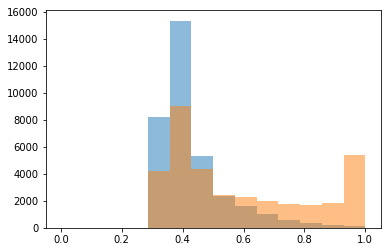

In [256]:
# Net output
bins = np.linspace(0, 1, 15)
_ = plt.hist(y_hat_proba_net[y_test == 0], alpha=0.5, bins=bins)
_ = plt.hist(y_hat_proba_net[y_test == 1], alpha=0.5, bins=bins)

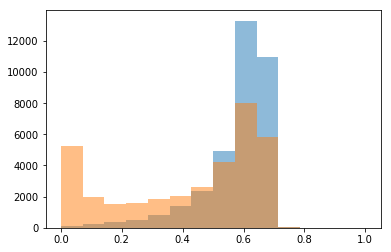

In [257]:
# BDT output
bins = np.linspace(0, 1, 15)
_ = plt.hist(y_hat_prob[:, 0][y_test == 0], alpha=0.5, bins=bins)
_ = plt.hist(y_hat_prob[:, 0][y_test == 1], alpha=0.5, bins=bins)

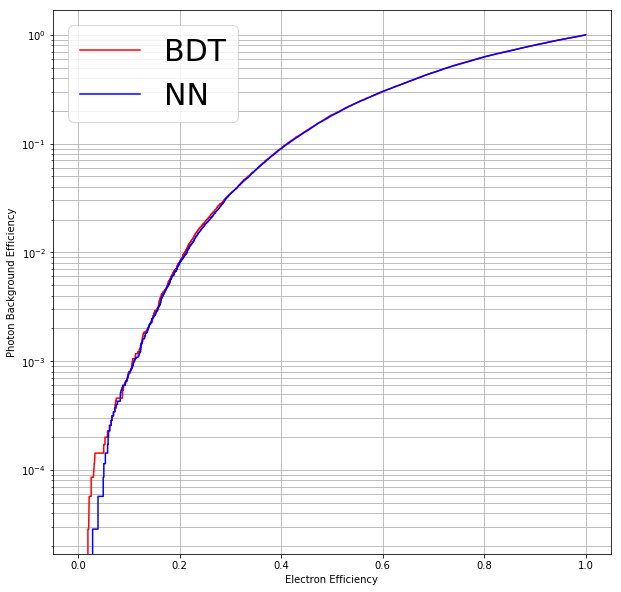

In [266]:
plt.figure(figsize=(10,10))
plt.plot(tpr, fpr, color='red', label='BDT')
plt.plot(tpr_net, fpr_net, color='blue', label='NN')
plt.yscale('log')
plt.grid('on', 'both')
plt.xlabel('Electron Efficiency')
plt.ylabel('Photon Background Efficiency')
plt.legend(fontsize=30)
# lower = better !!